**<span style="color:rgb(97, 97, 97);">In The Name of God</span>**

---

**<span style="color: rgb(97, 97, 97);">Erfan Falahati</span>**

**<span style="color: rgb(97, 97, 97);">SID:</span> <span style="color: rgb(97, 97, 97);">810102491</span>**

# **<span style="color: #3399FF;">Computer Assignment #5: Clustering</span>**


In [1]:
import os
import re
import spacy
import string
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [2]:
plt.style.use('seaborn-v0_8')

DATASET_PATH = os.path.join('content', 'musicLyrics.csv')
CLEANED_DATASET_PATH = os.path.join('content', 'cleaned_dataset.csv')
LYRIC_EMBEDDINGS_PATH = os.path.join('content', 'lyric_embeddings.npy')
MODEL_PATH = os.path.join('content', 'exported_model')

# **<span style="color: #3399FF;">Dataset Overview</span>**

In [9]:
df = pd.read_csv(DATASET_PATH)
df.head()

,Lyric
0,Cryptic psalms Amidst the howling winds A scor...
1,Im sleeping tonight with all the wolves Were d...
2,Wings of the darkest descent Fall from the rea...
3,[Verse 1] Norrid Radd was my real name Had a j...
4,Deep in the dungeons of doom and despair Sneak...


## **<span style="color: #3399FF;">Description</span>**


In [10]:
df.describe()

,Lyric
count,2999
unique,2999
top,Cryptic psalms Amidst the howling winds A scor...
freq,1


## **<span style="color: #3399FF;">Check for NULL values</span>**

In [11]:
df.isnull().sum()

Lyric    0
dtype: int64

# **<span style="color: #3399FF;">Text Preprocessing and Feature Extraction</span>**

### Why Do We Preprocess Text Data?

- **Reduce noise:** Remove irrelevant characters (punctuation, numbers, etc.).
- **Standardize text:** Lowercasing, removing stopwords, etc.
- **Improve model performance:** Clean input leads to better feature extraction.
- **Reduce dimensionality:** Normalize word forms (e.g., "playing", "played" → "play").
- **Enhance learning:** Helps clustering/classification algorithms better understand patterns.


### Why Do We Extract Features from Text?

- **Text is unstructured:** Raw text cannot be directly used in most machine learning models.
- **Numerical representation needed:** Models require numeric vectors (e.g., embeddings) to process text.
- **Capture meaning and context:** Feature extraction methods (like TF-IDF, BERT, etc.) help represent semantic information.
- **Enable clustering/classification:** Without features, we can't group or label text effectively.
- **Improve performance and accuracy:** Good features lead to better model understanding and results.


### Why Use Stemming or Lemmatization?

- **Normalize word forms:** Converts different forms of a word into a single base form.
  - e.g., "running", "ran", "runs" → "run"
- **Reduce vocabulary size:** Fewer distinct tokens make models more efficient.
- **Improve pattern recognition:** Helps algorithms detect shared meanings and structures.
- **Stemming:** Cuts words mechanically (faster, but may produce non-words).
- **Lemmatization:** Uses linguistic knowledge to return dictionary base forms (more accurate).


In [ ]:
nlp = spacy.load("en_core_web_sm")


stop_words = set(stopwords.words("english"))

def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", "", text)
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and token.lemma_ not in string.punctuation]
    return " ".join(tokens)

df["preprocessed_lyric"] = df["Lyric"].apply(preprocess)

In [ ]:
df.to_csv(CLEANED_DATASET_PATH, index=False)

 # **<span style="color: #3399FF;">Text Embedding and Unsupervised Clustering of Lyrics</span>**

In [14]:
df = pd.read_csv(CLEANED_DATASET_PATH)

In [15]:
if os.path.exists(LYRIC_EMBEDDINGS_PATH):
    embeddings = np.load(LYRIC_EMBEDDINGS_PATH)
else:
    model = SentenceTransformer(MODEL_PATH)
    embeddings = model.encode(df["preprocessed_lyric"].tolist(), show_progress_bar=True)
    np.save(LYRIC_EMBEDDINGS_PATH, embeddings)

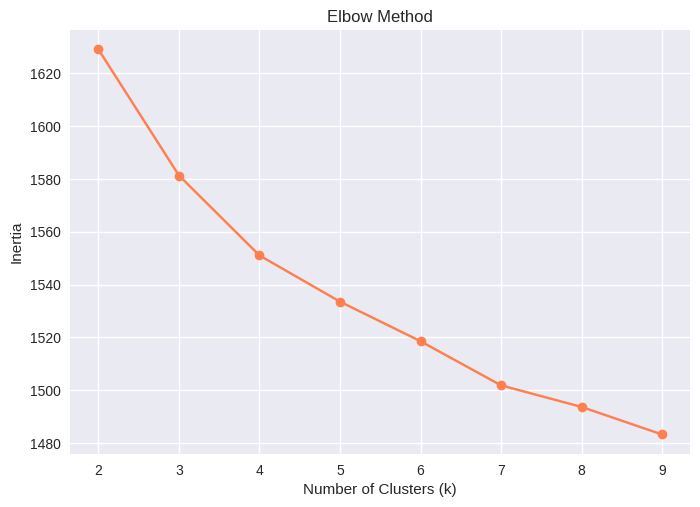

In [16]:
inertias = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=491)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)

plt.plot(K_range, inertias, marker="o", color='coral')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.grid(True)
plt.show()


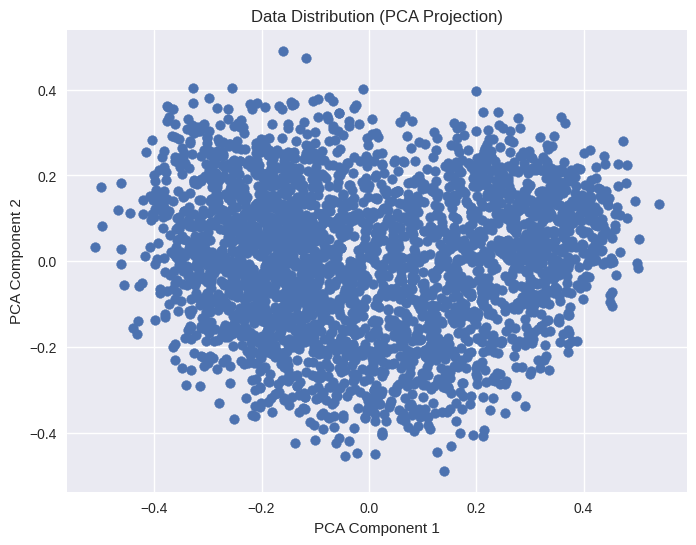

In [17]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

df["pca1"] = reduced[:, 0]
df["pca2"] = reduced[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(df["pca1"], df["pca2"])
plt.title("Data Distribution (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()


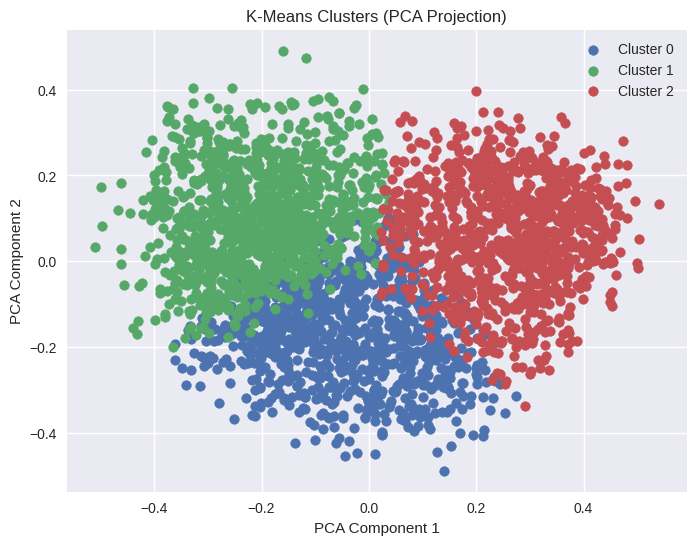

In [18]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=491)
df["cluster_kmeans"] = kmeans.fit_predict(embeddings)

plt.figure(figsize=(8, 6))
for cluster_id in sorted(df["cluster_kmeans"].unique()):
    cluster_points = df[df["cluster_kmeans"] == cluster_id]
    plt.scatter(cluster_points["pca1"], cluster_points["pca2"], label=f"Cluster {cluster_id}")

plt.title("K-Means Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

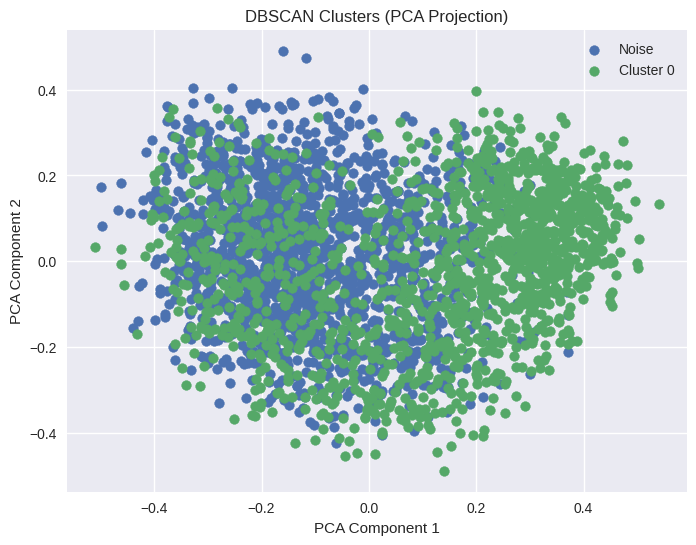

In [19]:
dbscan = DBSCAN(eps=0.3, min_samples=4, metric="cosine")
df["cluster_dbscan"] = dbscan.fit_predict(embeddings)

plt.figure(figsize=(8, 6))
for cluster_id in sorted(df["cluster_dbscan"].unique()):
    cluster_points = df[df["cluster_dbscan"] == cluster_id]
    label = f"Cluster {cluster_id}" if cluster_id != -1 else "Noise"
    plt.scatter(cluster_points["pca1"], cluster_points["pca2"], label=label)
plt.title("DBSCAN Clusters (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()

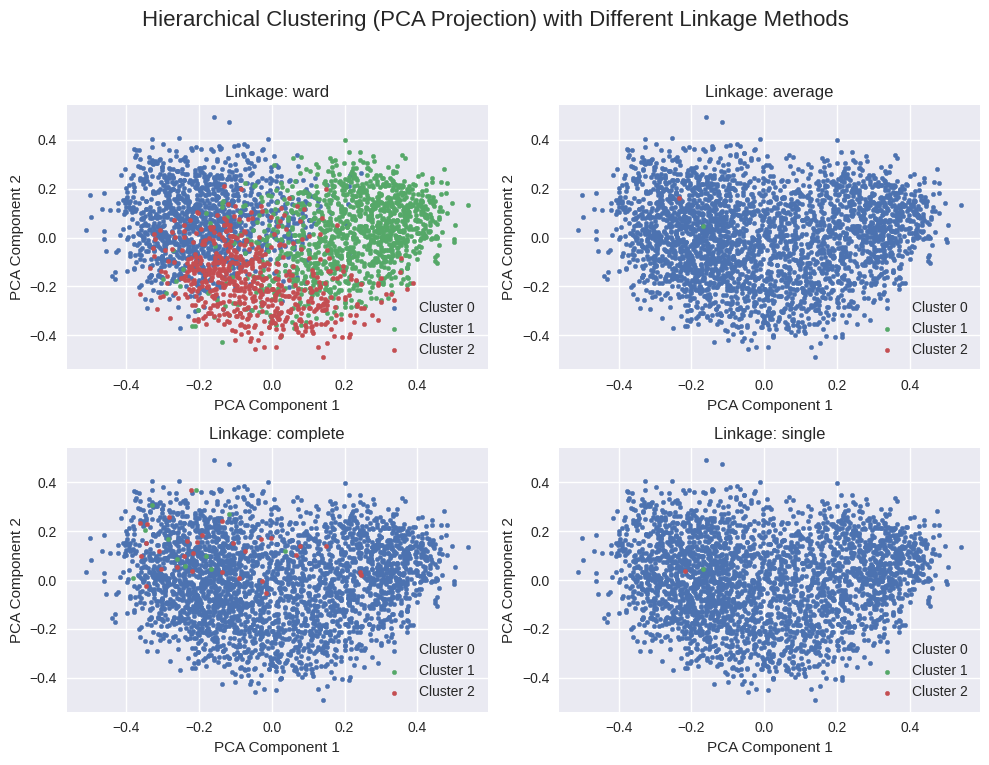

In [20]:
linkage_methods = ["ward", "average", "complete", "single"]
k = 3

plt.figure(figsize=(10, 8))

for i, method in enumerate(linkage_methods):
    if method == "ward":
        model = AgglomerativeClustering(n_clusters=k, linkage=method)
    else:
        model = AgglomerativeClustering(n_clusters=k, linkage=method, metric="cosine")

    df[f"cluster_{method}"] = model.fit_predict(embeddings)

    plt.subplot(2, 2, i + 1)
    for cluster_id in sorted(df[f"cluster_{method}"].unique()):
        cluster_points = df[df[f"cluster_{method}"] == cluster_id]
        plt.scatter(cluster_points["pca1"], cluster_points["pca2"], label=f"Cluster {cluster_id}", s=10)

    plt.title(f"Linkage: {method}")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend()
    plt.grid(True)

plt.suptitle("Hierarchical Clustering (PCA Projection) with Different Linkage Methods", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


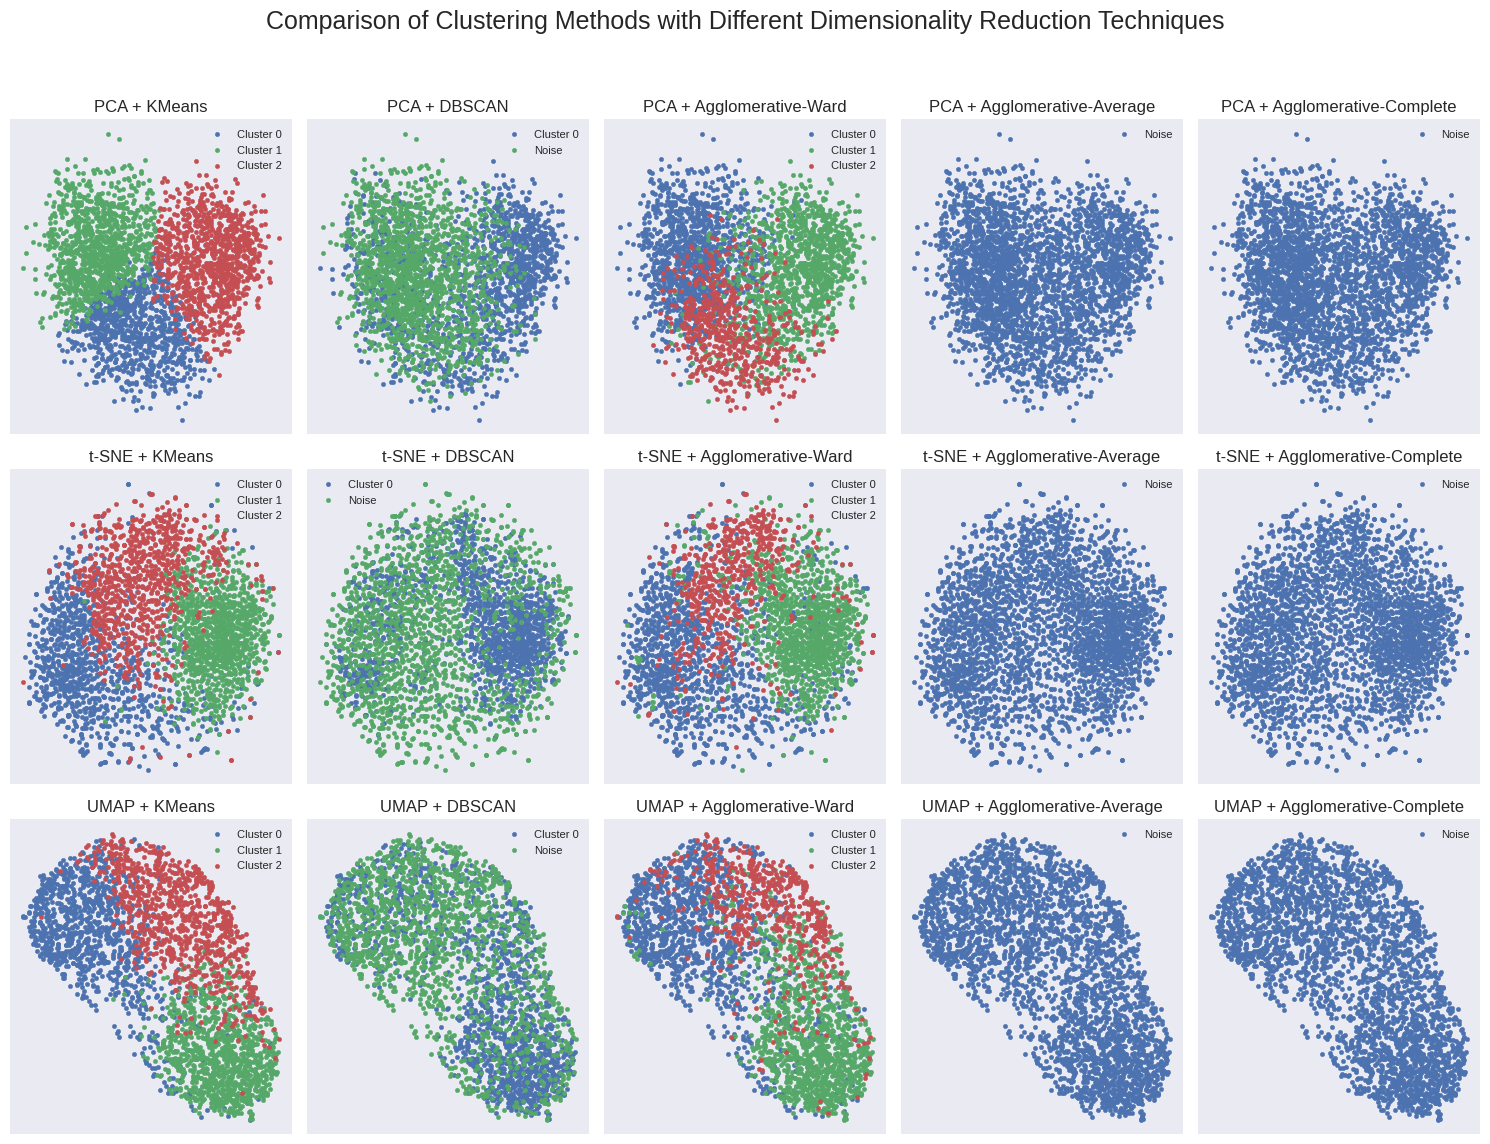

In [21]:
reduction_methods = {
    "PCA": PCA(n_components=2),
    "t-SNE": TSNE(n_components=2, perplexity=30),
    "UMAP": umap.UMAP(n_components=2)
}

clustering_methods = {
    "KMeans": lambda X: KMeans(n_clusters=3).fit_predict(X),
    "DBSCAN": lambda X: DBSCAN(eps=0.3, min_samples=4, metric="cosine").fit_predict(X),
    "Agglomerative-Ward": lambda X: AgglomerativeClustering(n_clusters=3, linkage="ward").fit_predict(X),
    "Agglomerative-Average": lambda X: AgglomerativeClustering(n_clusters=3, linkage="average", affinity="cosine").fit_predict(X),
    "Agglomerative-Complete": lambda X: AgglomerativeClustering(n_clusters=3, linkage="complete", affinity="cosine").fit_predict(X),
}

fig, axes = plt.subplots(len(reduction_methods), len(clustering_methods), figsize=(15, 12))
fig.suptitle("Comparison of Clustering Methods with Different Dimensionality Reduction Techniques", fontsize=18)

for row_idx, (red_name, reducer) in enumerate(reduction_methods.items()):
    reduced = reducer.fit_transform(embeddings)
    for col_idx, (clust_name, cluster_func) in enumerate(clustering_methods.items()):
        try:
            labels = cluster_func(embeddings)
        except:
            labels = [-1] * len(embeddings)
        ax = axes[row_idx, col_idx]
        for label in set(labels):
            points = reduced[[i for i, l in enumerate(labels) if l == label]]
            label_name = f"Cluster {label}" if label != -1 else "Noise"
            ax.scatter(points[:, 0], points[:, 1], label=label_name, s=10)
        ax.set_title(f"{red_name} + {clust_name}")
        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend(fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Dimensionality Reduction: PCA
 Clustering: KMeans


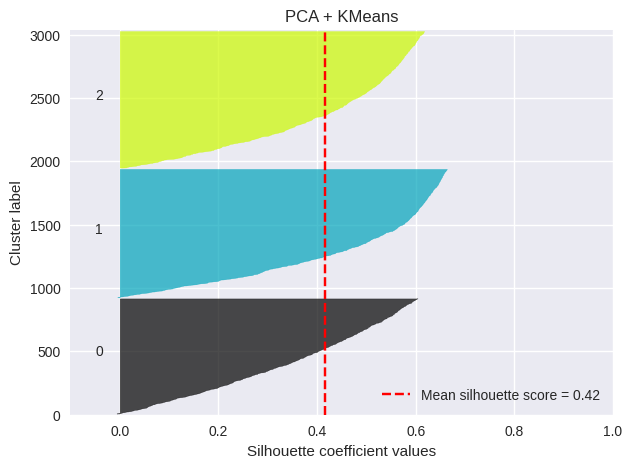

Skipped!
 Clustering: Agglomerative-Ward


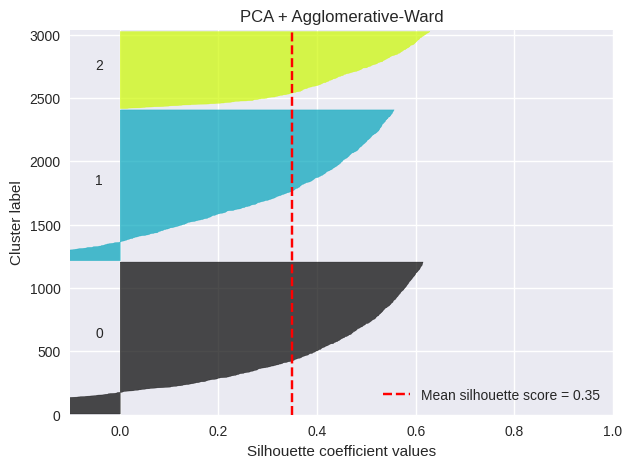

 Clustering: Agglomerative-Average


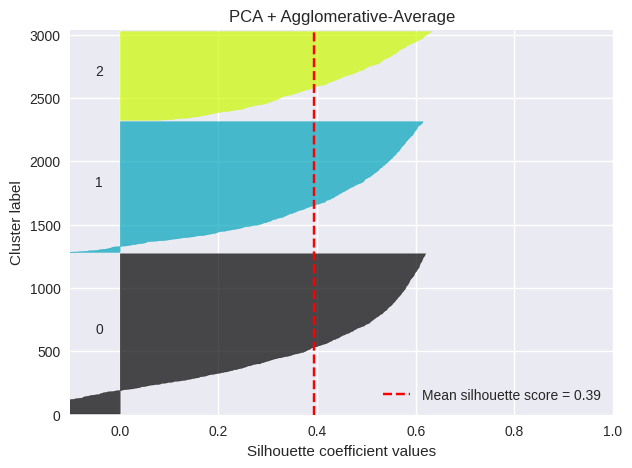

 Clustering: Agglomerative-Complete


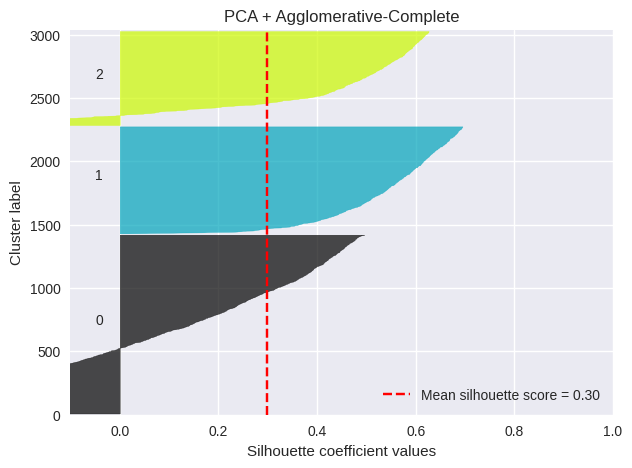

Dimensionality Reduction: t-SNE
 Clustering: KMeans


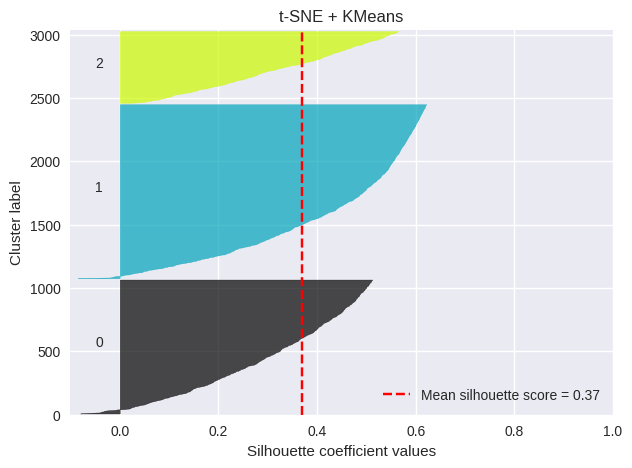

Skipped!
 Clustering: Agglomerative-Ward


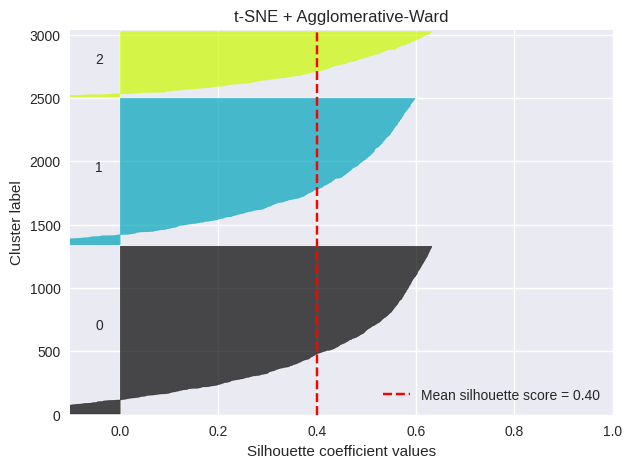

 Clustering: Agglomerative-Average


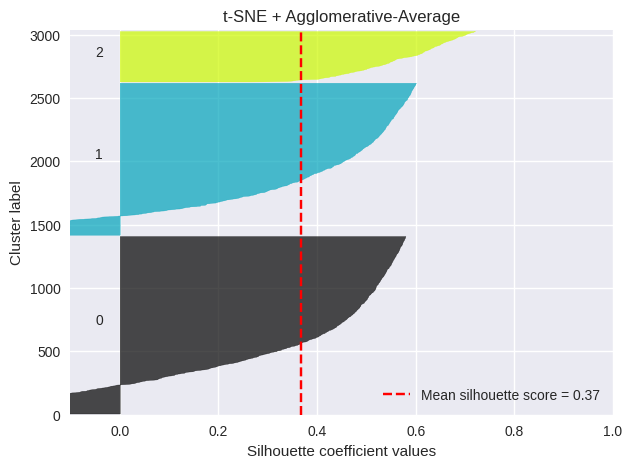

 Clustering: Agglomerative-Complete


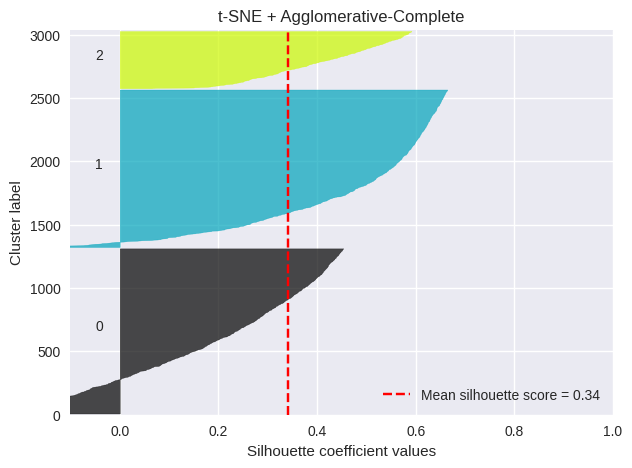

Dimensionality Reduction: UMAP
 Clustering: KMeans


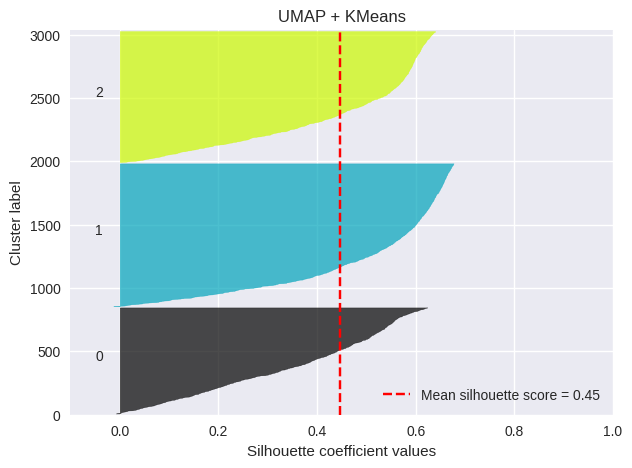

Skipped!
 Clustering: Agglomerative-Ward


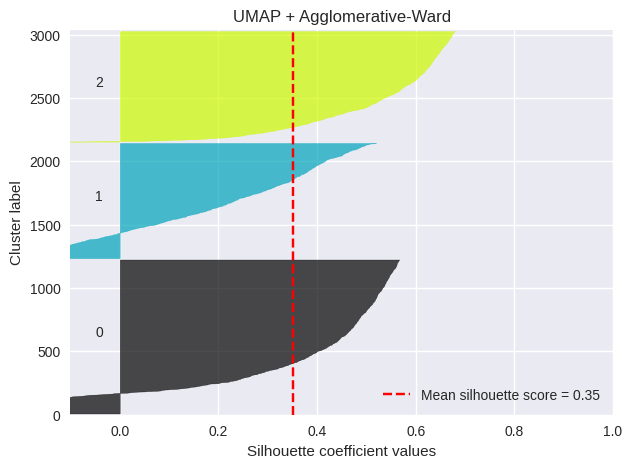

 Clustering: Agglomerative-Average


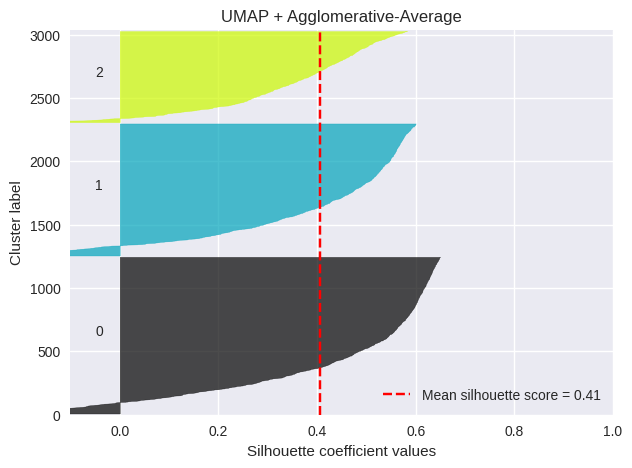

 Clustering: Agglomerative-Complete


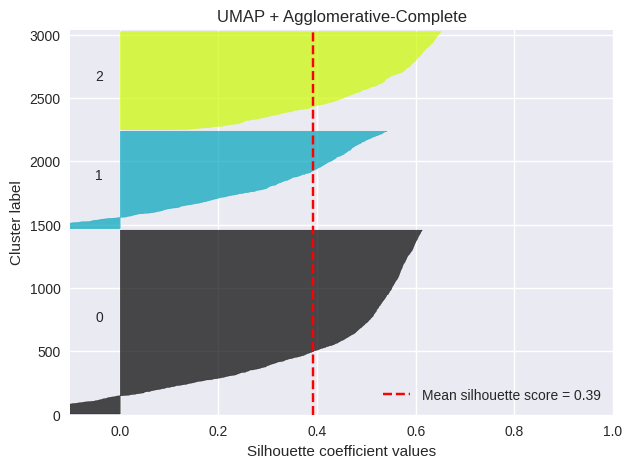

In [22]:

def detailed_silhouette_analysis(X, cluster_labels, title="Silhouette Analysis"):
    n_clusters = len(np.unique(cluster_labels))
    if n_clusters <= 1 or -1 in np.unique(cluster_labels) and len(np.unique(cluster_labels)) <= 2:
        print(f"Cannot compute silhouette plot: insufficient clusters ({n_clusters})")
        return

    sil_samples = silhouette_samples(X, cluster_labels)
    mean_score = silhouette_score(X, cluster_labels)
    
    fig, ax = plt.subplots(figsize=(7, 5))
    y_lower = 10
    for i in range(n_clusters):
        cluster_sil_values = sil_samples[cluster_labels == i]
        cluster_sil_values.sort()
        size_cluster = cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster

        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_sil_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i))
        y_lower = y_upper + 10  

    ax.axvline(x=mean_score, color="red", linestyle="--", label=f"Mean silhouette score = {mean_score:.2f}")
    ax.set_title(title)
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Cluster label")
    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, y_lower])
    ax.legend()
    plt.show()

reduction_methods = {
    "PCA": PCA(n_components=2),
    "t-SNE": TSNE(n_components=2, perplexity=30),
    "UMAP": umap.UMAP(n_components=2),
}

def kmeans_func(X):
    model = KMeans(n_clusters=3, random_state=42).fit(X)
    return model, model.labels_

def dbscan_func(X):
    model = DBSCAN(eps=0.3, min_samples=4, metric="cosine").fit(X)
    return model, model.labels_

def agglom_ward_func(X):
    model = AgglomerativeClustering(n_clusters=3, linkage="ward").fit(X)
    return model, model.labels_

def agglom_avg_func(X):
    model = AgglomerativeClustering(n_clusters=3, linkage="average", metric="cosine").fit(X)
    return model, model.labels_

def agglom_complete_func(X):
    model = AgglomerativeClustering(n_clusters=3, linkage="complete", metric="cosine").fit(X)
    return model, model.labels_

clustering_methods = {
    "KMeans": kmeans_func,
    "DBSCAN": dbscan_func,
    "Agglomerative-Ward": agglom_ward_func,
    "Agglomerative-Average": agglom_avg_func,
    "Agglomerative-Complete": agglom_complete_func,
}


for red_name, reducer in reduction_methods.items():
    X_reduced = reducer.fit_transform(embeddings)
    print(f"Dimensionality Reduction: {red_name}")
    
    for clust_name, cluster_func in clustering_methods.items():
        model, labels = cluster_func(X_reduced)
        unique_labels = np.unique(labels)
        if len(unique_labels) > 1 and len(set(labels)) < len(embeddings):
            print(f" Clustering: {clust_name}")
            detailed_silhouette_analysis(X_reduced, labels, title=f"{red_name} + {clust_name}")
        else:
            print("Skipped!")


## **Explanation of Clustering Methods, Text Vectorization, Transformer Models, and Elbow Method in K-means**
---

## 1. Clustering Methods

### K-means
- Partitions data into *k* clusters by minimizing variance within clusters.
- Requires predefining the number of clusters (*k*).
- Efficient and simple, but sensitive to initial centroids and outliers.

### DBSCAN
- Density-based clustering; finds clusters based on density of points.
- Can detect arbitrarily shaped clusters and noise points.
- Does not require specifying number of clusters beforehand.
- Less sensitive to outliers.

### Hierarchical Clustering
- Builds a tree (dendrogram) of clusters by either merging or splitting.
- No need to specify cluster number initially.
- Can capture nested clusters but computationally expensive.

---

## 2. Text Vectorization Methods

### Methods
- **Bag of Words (BoW):** Counts word occurrences, ignores order.
- **TF-IDF:** Weighs words based on frequency and inverse document frequency.
- **Word Embeddings (e.g., Word2Vec, GloVe):** Dense vectors capturing semantic meaning.
- **Sentence Embeddings:** Represent entire sentences in vector form.

### Advantages and Disadvantages

| Method         | Advantages                          | Disadvantages                      |
|----------------|-----------------------------------|----------------------------------|
| BoW            | Simple and interpretable           | Ignores word order and context   |
| TF-IDF         | Highlights important words         | Still ignores semantics          |
| Word Embeddings| Capture semantic relations         | Require large training data      |
| Sentence Embeddings | Represent meaning at sentence level | Computationally heavier         |

---

## 3. Transformer Sentence Models & all-MiniLM-L6-v2

- **Transformer Models:** Use attention mechanisms to capture contextual relationships in text; state-of-the-art in NLP.
- **Sentence Transformers:** Extend transformers to produce fixed-size embeddings for sentences or paragraphs.
- **all-MiniLM-L6-v2:** A lightweight, efficient Sentence Transformer model producing 384-dimensional embeddings, optimized for speed and decent accuracy on semantic similarity tasks.

---

## 4. Elbow Method in K-means

- Used to find the optimal number of clusters (*k*).
- Plot *k* vs. Within-Cluster-Sum-of-Squares (WCSS).
- The "elbow" point where WCSS reduction slows indicates best *k*.
- Helps avoid over/under-clustering.

---

## 5. Comparison of Clustering Outputs on the Dataset

| Method          | Strengths                       | Weaknesses                        | Suitability on Dataset                   |
|-----------------|--------------------------------|----------------------------------|-----------------------------------------|
| K-means         | Fast, intuitive clusters        | Needs *k*; sensitive to outliers | Good if clusters are spherical & well-separated |
| DBSCAN          | Handles noise; finds arbitrary shapes | Struggles with varying densities  | Better if data has noise or irregular clusters |
| Hierarchical    | Flexible cluster granularity    | Computationally intensive         | Useful for understanding cluster hierarchy |

### Which Method Performs Better?

- If dataset has noise and irregular clusters, **DBSCAN** usually performs better.
- If clusters are well-defined and roughly spherical, **K-means** is efficient and effective.
- For understanding nested cluster structures, **Hierarchical clustering** is preferred.

## **Principal Component Analysis (PCA)**

## What is PCA ?
- A dimensionality reduction technique.
- Transforms high-dimensional data into a lower-dimensional space.
- Keeps the most important information (variance) while reducing noise and redundancy.

## How PCA Works ?
1. **Standardize Data:** Center data by subtracting the mean.
2. **Compute Covariance Matrix:** Measures how features vary together.
3. **Calculate Eigenvectors and Eigenvalues:** Find principal components that capture directions of maximum variance.
4. **Select Top Components:** Choose components with highest eigenvalues.
5. **Transform Data:** Project original data onto selected principal components.

## Benefits
- Reduces dimensionality while preserving variance.
- Speeds up computation and visualization.
- Helps remove correlated features.

## Limitations
- Components are linear combinations, can be hard to interpret.
- Assumes linear relationships.


# **<span style="color: #3399FF;">Evaluation and Analysis</span>**

In [25]:
sil_kmeans = silhouette_score(embeddings, df["cluster_kmeans"])
sil_dbscan = silhouette_score(embeddings, df["cluster_dbscan"])
sil_hier = silhouette_score(embeddings, df["cluster_ward"])

print("Silhouette Scores:")
print(f"K-Means: {sil_kmeans:.3f}")
print(f"DBSCAN: {sil_dbscan:.3f}")
print(f"Hierarchical: {sil_hier:.3f}")


Silhouette Scores:
K-Means: 0.050
DBSCAN: 0.034
Hierarchical: 0.037


In [27]:
for method in ["cluster_kmeans", "cluster_dbscan", "cluster_ward"]:
    print(f"\n===== Samples for {method} =====")
    for cluster_id in df[method].dropna().unique():
        print(f"\n--- Cluster {cluster_id} ---")
        samples = df[df[method] == cluster_id]["Lyric"].head(2)
        for i, text in enumerate(samples, 1):
            print(f"Sample {i}: {text[:200]}...")


===== Samples for cluster_kmeans =====

--- Cluster 1 ---
Sample 1: Cryptic psalms Amidst the howling winds A scorching source of agonizing bliss Beneath its veil Mysteries of a life beyond Can you hear it? Sons and daughters with hearts ablaze Forsaken ones in deaths...
Sample 2: Wings of the darkest descent Fall from the realm of dark From the blackest fall of creation Doomed by its end Winds of chaos blow through my soul Wings of the darkest descent shall fall Lurking evil s...

--- Cluster 0 ---
Sample 1: Im sleeping tonight with all the wolves Were dreaming of life thats better planned As long as the wind that falls isnt longing for revenge I should be safe We should be safe Shes two bitter ends So wa...
Sample 2: [Verse 1] Norrid Radd was my real name Had a job that I hated every day Until that one day I told my boss To just shove that damn JOB Cause I found a place I could rest my head, maybe call my home Tra...

--- Cluster 2 ---
Sample 1: Dont look at me that way Like you kno

## **Clustering Evaluation Metrics Explained**

## Silhouette Score
- **Purpose:** Measures how well each point fits into its assigned cluster.
- **How it works:**  
  - Calculates the average distance between a point and others in the same cluster (a).  
  - Calculates the average distance between the point and points in the nearest different cluster (b).  
  - Silhouette value for the point:  
    $$ s = \frac{b - a}{\max(a, b)} $$
- **Interpretation:**  
  - Close to 1: Point is well matched to its cluster.  
  - Around 0: Point is on the boundary between clusters.  
  - Negative: Point might be in the wrong cluster.  
- **Use case:** Works without needing true labels, useful for unsupervised clustering evaluation.

---

## Homogeneity Score
- **Purpose:** Measures whether each cluster contains only data points from a single class.
- **How it works:**  
  - Uses class labels and cluster assignments to compute conditional entropy.  
  - Score is between 0 and 1.  
  - 1 means perfect homogeneity (each cluster has only one class).
- **Interpretation:**  
  - Higher scores mean clusters align well with true classes.  
- **Use case:** Requires known true labels, so not applicable if labels are missing.

---

**Summary:**  
- Use **Silhouette Score** when no labels are available (common in clustering).  
- Use **Homogeneity Score** only if you have ground truth labels.
